In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch

In [5]:
data_path = r'/home/check/DATA/university/yr3, hk1/DS102 - ML for Statistic/Đồ án/goodread/DS102/DATA/gold/'
models_path = r'/home/check/DATA/university/yr3, hk1/DS102 - ML for Statistic/Đồ án/goodread/DS102/models/BERT + XGB/'

In [6]:
test_df = pd.read_csv(data_path + 'v2/test_2.csv')
model = joblib.load(models_path + 'bert_xgb.joblib')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [8]:
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(emb)
    return np.vstack(embeddings)

In [9]:
test_texts = (test_df['description'].fillna('') + ' [SEP] ' + test_df['review_text'].fillna('')).tolist()
test_bert_emb = get_bert_embeddings(test_texts)

In [10]:
feature_cols = [col for col in test_df.columns if col not in ['title', 'author', 'description', 'review_text', 'Commercial_success', 'Popular_success', 'Critical_success']]
X_test = np.hstack([test_df[feature_cols].values, test_bert_emb])
y_test = test_df[['Commercial_success', 'Popular_success', 'Critical_success']].values - 1

y_pred = model.predict(X_test)


Classification Report for Commercial_success:
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98        84
     Class 1       0.96      0.98      0.97        55
     Class 2       1.00      0.88      0.93        56
     Class 3       0.84      1.00      0.91        89
     Class 4       1.00      0.92      0.96       129

    accuracy                           0.95       413
   macro avg       0.96      0.95      0.95       413
weighted avg       0.96      0.95      0.95       413



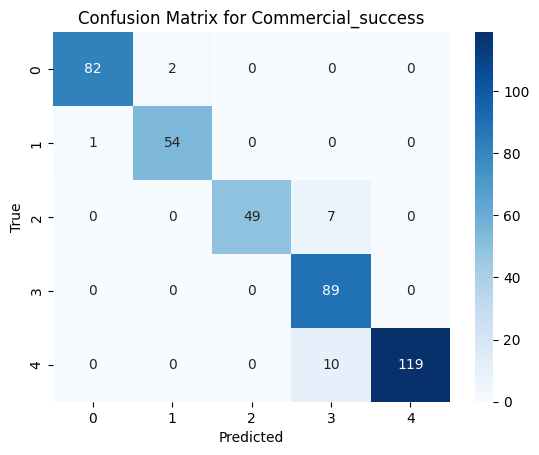


Classification Report for Popular_success:
              precision    recall  f1-score   support

     Class 0       0.99      0.94      0.96        70
     Class 1       0.80      0.86      0.83        95
     Class 2       0.76      0.74      0.75        94
     Class 3       0.82      0.89      0.85       100
     Class 4       0.98      0.78      0.87        54

    accuracy                           0.85       413
   macro avg       0.87      0.84      0.85       413
weighted avg       0.85      0.85      0.85       413



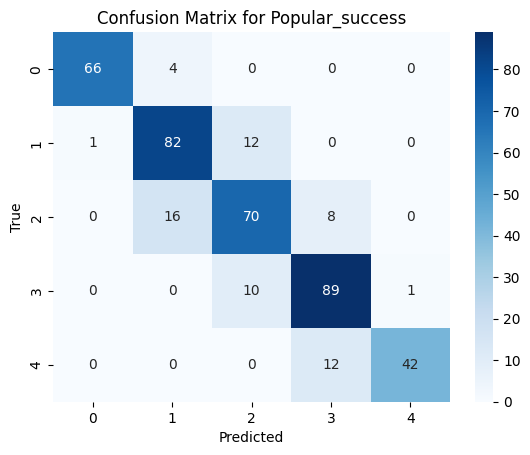


Classification Report for Critical_success:
              precision    recall  f1-score   support

     Class 0       0.75      0.35      0.47        26
     Class 1       0.50      0.74      0.60        97
     Class 2       0.71      0.59      0.64       123
     Class 3       0.94      0.86      0.90        92
     Class 4       0.96      0.93      0.95        75

    accuracy                           0.73       413
   macro avg       0.77      0.69      0.71       413
weighted avg       0.76      0.73      0.73       413



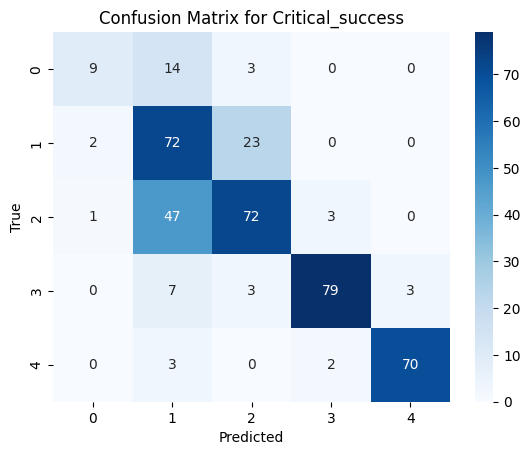

In [11]:
labels = ['Commercial_success', 'Popular_success', 'Critical_success']
for i, label in enumerate(labels):
    print(f"\nClassification Report for {label}:")
    print(classification_report(y_test[:, i], y_pred[:, i], target_names=[f'Class {j}' for j in range(5)]))
    
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [12]:
acc = accuracy_score(y_test.ravel(), y_pred.ravel())
f1 = f1_score(y_test.ravel(), y_pred.ravel(), average='macro')
print(f"\nOverall Accuracy: {acc:.4f}")
print(f"Overall F1-score (macro): {f1:.4f}")


Overall Accuracy: 0.8426
Overall F1-score (macro): 0.8485


In [13]:
importances = []
for est in model.estimators_:
    importances.append(est.feature_importances_)
avg_importance = np.mean(importances, axis=0)

In [16]:
top_n = 30
sorted_idx = np.argsort(avg_importance)[::-1][:top_n]
top_importances = avg_importance[sorted_idx]
top_feature_names = [all_feature_names[i] for i in sorted_idx]

In [17]:
importance_df = pd.DataFrame({
    'Feature': top_feature_names,
    'Importance': top_importances
})

/tmp/ipykernel_33315/4280462880.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')


<Axes: xlabel='Importance', ylabel='Feature'>

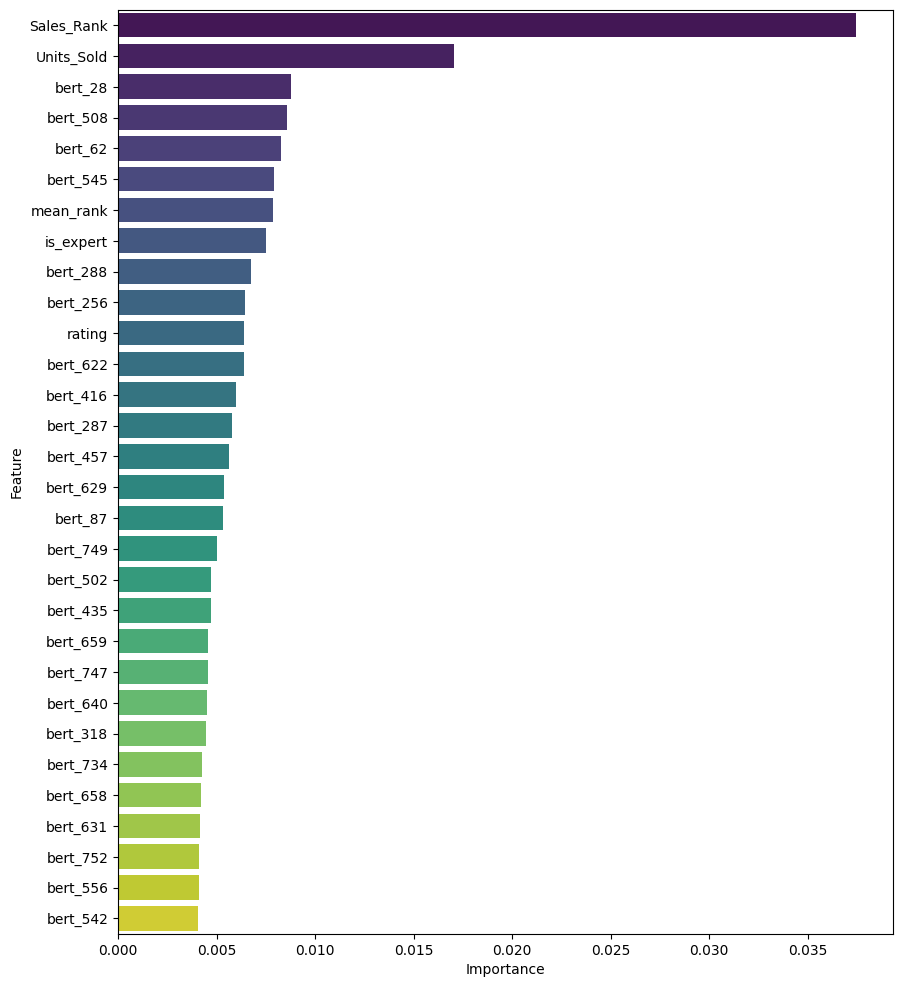

In [22]:
plt.figure(figsize=(10, 12))
sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')